In [106]:
using Pkg
Pkg.activate("../")

using Revise
using ProbabilisticFSMs

 Activating environment at `~/GithubRepositories/ProbabilisticFSMs/Project.toml`


In [ ]:
"a" -> 1, 2, 3
"b" -> 4, 5, 6

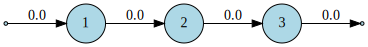

In [109]:
function makehmm(pdfidxs)
    fsm = FSM()
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        
        # We don't add the self-loop now otherwise
        # the minimization algorithm will fail
        # link!(fsm, state, state) 
        
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
    fsm |> weightnormalize
end

hmms = Dict()
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end
hmms["a"]

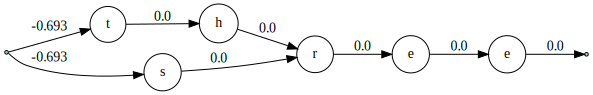

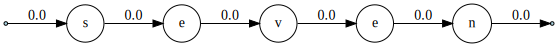

In [116]:
spelling = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  # French pronunciation 😁
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM()
    prevstate = initstate(fsm)
    for letter in pronunciation
        state = addstate!(fsm, label = letter)
        link!(fsm, prevstate, state)
        prevstate = state
    end
    link!(fsm, prevstate, finalstate(fsm))
    fsm
end

lexicon = Dict()
for (word, pronunciations) in spelling
    lexicon[word] = union(makepronunciation.(pronunciations)...) |> minimize
end

display(lexicon["three"])
display(lexicon["seven"])

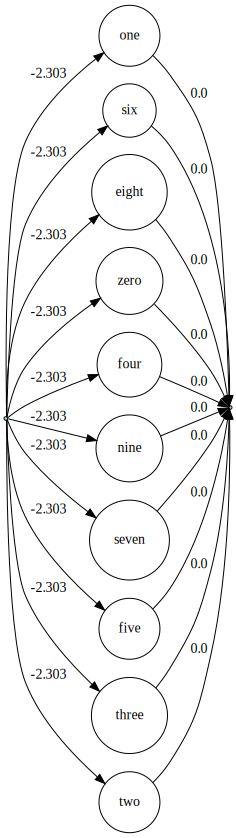

In [117]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(lm, initstate(lm), s)
    link!(lm, s, finalstate(lm))
end
#link!(lm, finalstate(lm), initstate(lm))
lm = lm |> weightnormalize

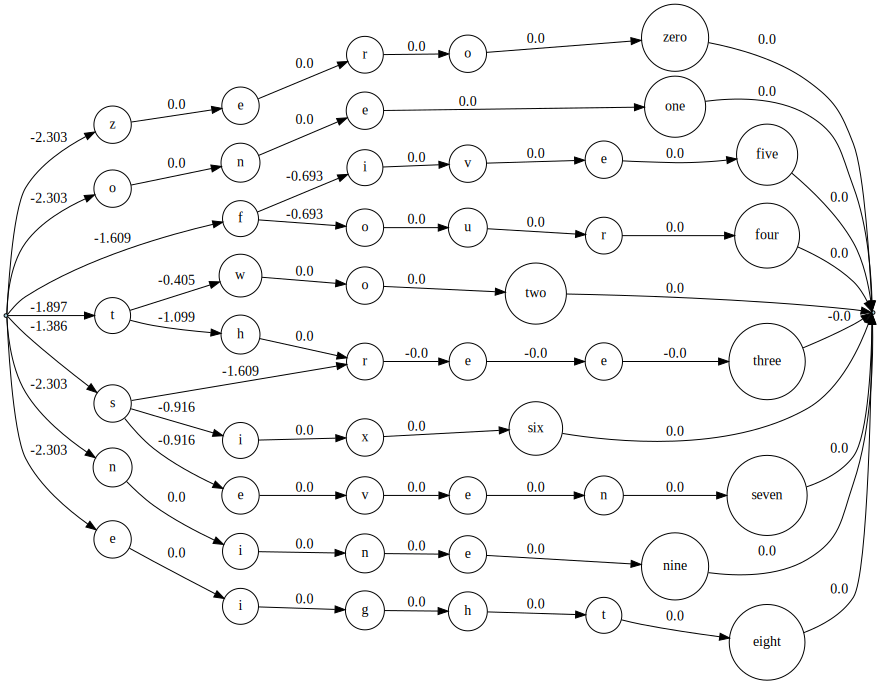

In [120]:
function replace!(fsm, state, subfsm)
    incoming = [link for link in parents(fsm, state)]
    outgoing = [link for link in children(fsm, state)]
    removestate!(fsm, state)
    idmap = Dict{StateID, State}()
    for s in states(subfsm)
        label = s.id == finalstateid ? "$(state.label)" : s.label
        ns = addstate!(fsm, pdfindex = s.pdfindex, label = label)
        idmap[s.id] = ns
    end
    
    for link in links(subfsm)
        link!(fsm, idmap[link.src.id], idmap[link.dest.id], link.weight)
    end
    
    for link in incoming link!(fsm, link.dest, idmap[initstateid], link.weight) end
    for link in outgoing link!(fsm, idmap[finalstateid], link.dest, link.weight) end
    fsm
end

function compose!(fsm, subfsms)
    toreplace = State[]
    for state in states(fsm)
        if state.label ∈ keys(subfsms) push!(toreplace, state) end
    end
    for state in toreplace replace!(fsm, state, subfsms[state.label]) end
    fsm
end

newlm = deepcopy(lm)
compose!(newlm, lexicon) |> minimize

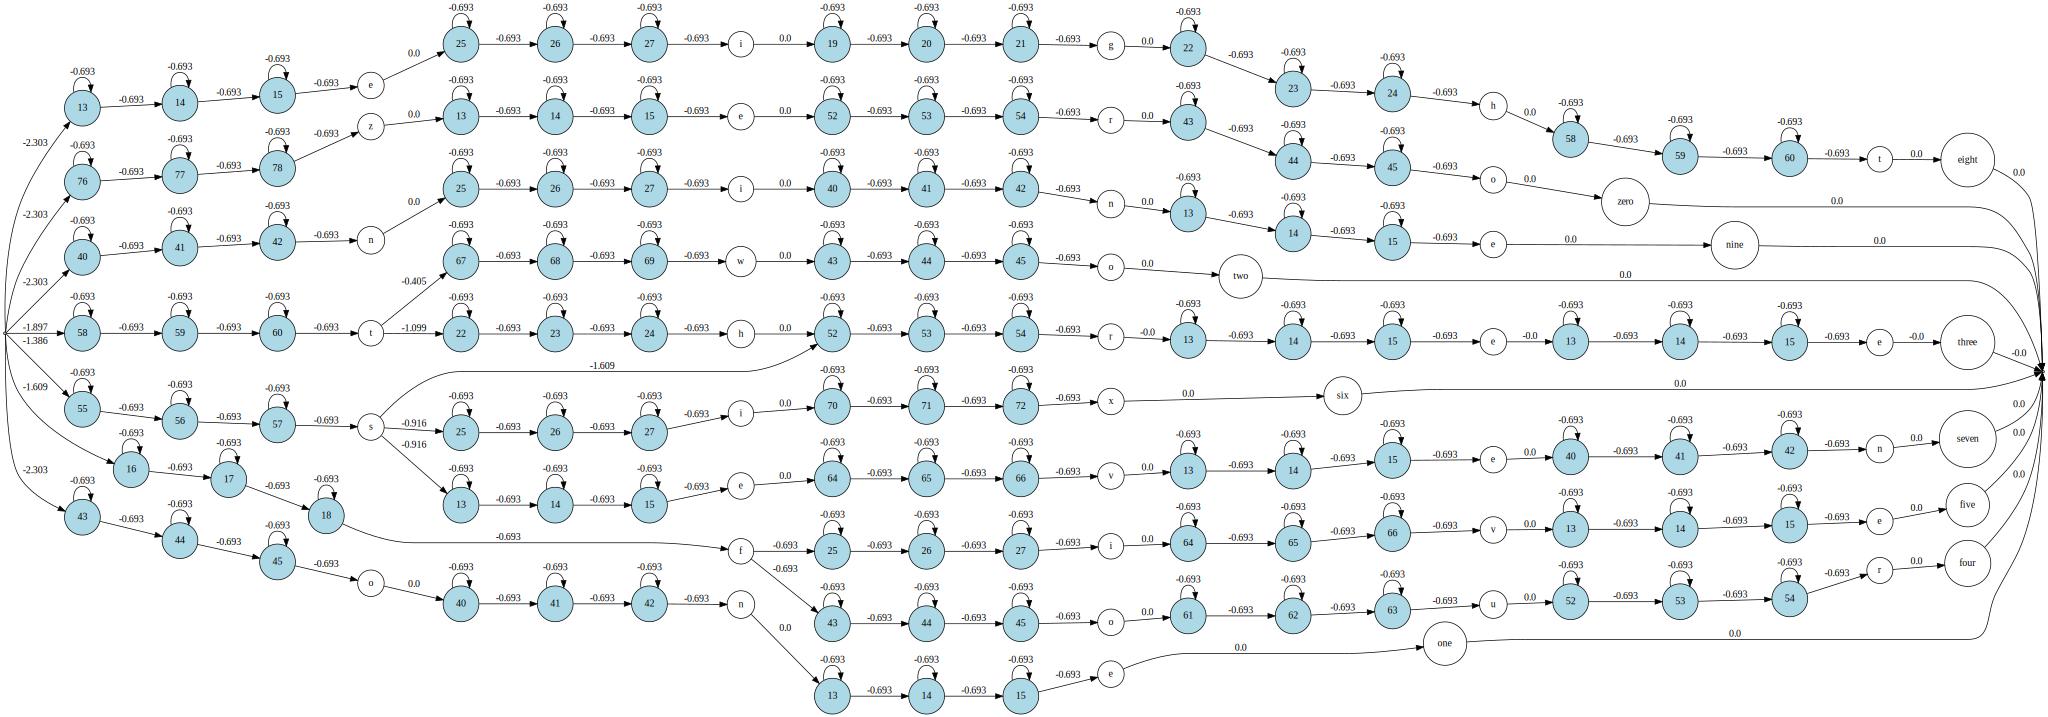

In [121]:
newlm = deepcopy(lm)
compose!(compose!(newlm, lexicon), hmms) |> minimize |> addselfloop

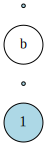

In [3]:
fsm = FSM()
addstate!(fsm, pdfindex = 1)
addstate!(fsm, label = "b")
fsm

In [122]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)

fsm = FSM()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

1-element Array{Link,1}:
 Link{Float64}(State(finalstateid), State(3, pdfindex = 3), 0.0)

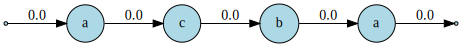

In [123]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissionsmap)

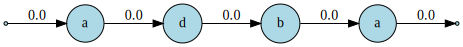

In [124]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissionsmap)

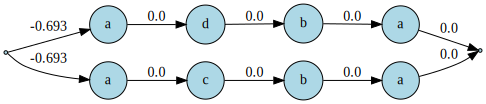

In [125]:
fsm = union(fsm1, fsm2)
fsm

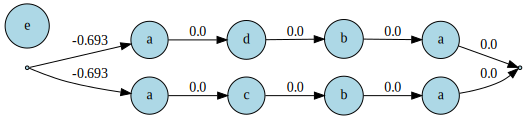

In [126]:
addstate!(fsm, pdfindex = 10, label = " e")
fsm

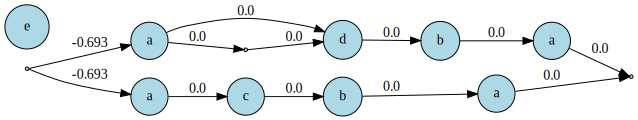

In [127]:
tmp = addstate!(fsm)
link!(fsm, fsm.states[6], tmp)
link!(fsm, tmp, fsm.states[7])
fsm

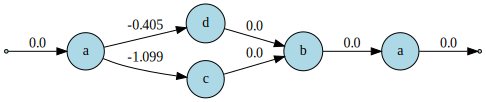

In [128]:
fsm = fsm |> minimize 

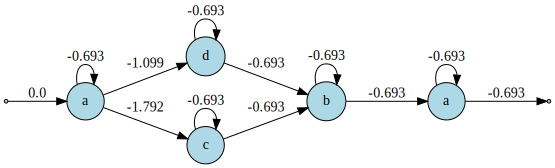

In [129]:
fsm = fsm |> addselfloop

In [130]:
D,N = 4, 10 # number of distributions times number of frames
v = randn(N, 1) .- 6 
llh = repeat(v', D)

4×10 Array{Float64,2}:
 -7.89341  -5.00526  -6.50832  -8.95114  …  -4.99946  -6.68117  -6.77058
 -7.89341  -5.00526  -6.50832  -8.95114     -4.99946  -6.68117  -6.77058
 -7.89341  -5.00526  -6.50832  -8.95114     -4.99946  -6.68117  -6.77058
 -7.89341  -5.00526  -6.50832  -8.95114     -4.99946  -6.68117  -6.77058

In [131]:
llh = zeros(4,5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [132]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [133]:
α = αrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
α

[n = 1]  	2	2 = 1.000  
[n = 2]  	2	1 = -0.792  	2 = 1.307  	3 = -0.099  
[n = 3]  	2	1 = 0.489  	2 = 1.114  	3 = 0.522  	5 = 1.067  
[n = 4]  	5	1 = 1.116  	2 = 0.921  	3 = 0.619  	4 = 0.873  	5 = 3.279  
[n = 5]  	5	1 = 2.519  	2 = 0.227  	3 = 1.337  	4 = 2.672  	5 = 3.442  


┌ Warning: `sort(d::Dict; args...)` is deprecated, use `sort!(OrderedDict(d); args...)` instead.
│   caller = ip:0x0
└ @ Core :-1


In [135]:
β = βrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
β

[n = 1]  	1	1 = 0.926  	2 = 0.412  	3 = 0.882  	4 = -0.773  	5 = 0.676  
[n = 2]  	1	1 = 0.715  	2 = -0.884  	3 = 0.601  	4 = -1.079  	5 = 0.601  
[n = 3]  	5	1 = -0.386  	3 = -0.386  	4 = -0.886  	5 = 0.088  
[n = 4]  	5	4 = -0.693  	5 = -0.693  
[n = 5]  	4	4 = 0.000  


In [136]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	2	2 = 0.000  
[n = 2]  	3	1 = -1.489  	2 = -0.989  	3 = -0.910  
[n = 3]  	5	1 = -1.588  	3 = -1.556  	5 = -0.537  
[n = 4]  	5	4 = -2.492  	5 = -0.086  
[n = 5]  	4	4 = 0.000  


In [108]:
path = viterbi(g, llh)

UndefVarError: UndefVarError: g not defined